Assiya Karatay karatay@bu.edu 8572947028 

**CS767 Machine Learning project**

**Image classification**

# Data Preprocessing


### Import libraries

In [1]:
# base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import os
import time
import json
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,classification_report


# for the model
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import Input
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization
# from keras.utils import image_dataset_from_directory
from keras.preprocessing import image
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

### Check the accelerator

In [2]:
print(tf.__version__)
print(keras.__version__)
if 'COLAB_TPU_ADDR' in os.environ: 
    print('Connected to TPU') 
elif tf.test.gpu_device_name() != '': 
    print('Connected to GPU ' + tf.test.gpu_device_name())
else:
    print('Neither connected to a TPU nor a GPU')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

2.8.0
2.8.0
Connected to GPU /device:GPU:0
Mon Apr 18 15:58:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    75W / 149W |    145MiB / 11441MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                             

### Initialize the parameters

In [3]:
seed = 96
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)                      
random.seed(seed)

In [4]:
# initialize the parameters
image_size = (128, 128)
batch_size = 32
val_split = 0.2
epoch=2
# set the path of the data
train_path = '/content/train'

### Extracting data

We use Kaggle API to download the dataset from Kaggle.

In [5]:
# create new API token (the file kaggle.json) of Kaggle account 
# locate it in the same folder as the code
data = {"username":"divassya","key":"2e54befaafd989955524784412ed81f0"}
with open('./kaggle.json', 'w') as f:
    json.dump(data, f, indent=2)
    print("kaggle.json file is created ")
time.sleep(5)    
! cp kaggle.json ~/.kaggle/
# change mode settings of the file
! chmod 600 ~/.kaggle/kaggle.json
from kaggle.api.kaggle_api_extended import KaggleApi

kaggle.json file is created 


In [6]:
# initialise the API
kag = KaggleApi()
kag.authenticate()

# downloading the files
kag.competition_download_files(competition='dogs-vs-cats', path='./')

# unzip the files
with ZipFile('dogs-vs-cats.zip', 'r') as z:
    z.extractall()
with ZipFile('train.zip', 'r') as z:
    z.extractall()

In [7]:
os.remove("test1.zip")
os.remove("train.zip")
os.remove("dogs-vs-cats.zip")
os.remove("sampleSubmission.csv")

In [8]:
# dataframe of labels
df = pd.DataFrame({'image_name':os.listdir(train_path)})
df['label'] =df['image_name'].apply(lambda x: x.split('.')[0])
df.head()

,image_name,label
0,dog.8011.jpg,dog
1,cat.11843.jpg,cat
2,cat.7618.jpg,cat
3,dog.816.jpg,dog
4,dog.7345.jpg,dog


In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
root_dir = "/content/gdrive/MyDrive/"

# choose where project files will be saved
project_folder = "CS767/project/"

# change the OS to use the project folder as the working directory
os.chdir(root_dir + project_folder)

print('\n Working directory was changed to ' + root_dir + project_folder )


 Working directory was changed to /content/gdrive/MyDrive/CS767/project/


### Splitting the data

* train_data
* validation_data
* test_data

In [11]:
train_val_data, test_data = train_test_split(df, 
                                        test_size = 0.2, 
                                        stratify = df["label"], 
                                        random_state = seed)
nb_test_samples = test_data.shape[0]
print(train_val_data.shape[0], nb_test_samples)
print(f'Size of test set: {nb_test_samples}')

20000 5000
Size of test set: 5000


In [12]:
train_data, val_data = train_test_split(train_val_data, 
                                        test_size = 0.2, 
                                        stratify = train_val_data["label"], 
                                        random_state = seed)

print(f'Size of train set: {train_data.shape[0]}\nSize of validation set: {val_data.shape[0]} values')

Size of train set: 16000
Size of validation set: 4000 values


# Data Visualization

### Show sample images


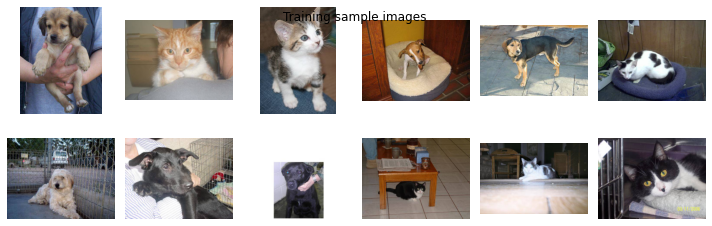

In [13]:
fig = plt.figure(1, figsize = (10, 10))
fig.suptitle("Training sample images ")

for i in range(12):

    plt.subplot(6, 6, i + 1)
    image = load_img(train_path + '/'+ df["image_name"][i])
    plt.imshow(image)
    plt.axis("off")
    
plt.tight_layout()
plt.savefig('./train_sample_images.png')
plt.show()

### Plot the loss and accuracy curves

In [14]:
# Plot the learning curve 
def learning_curve(hist):
    fit_df = pd.DataFrame.from_dict(hist.history)
    fit_df['epoch'] = fit_df.index + 1
    print(fit_df.head(2))
    fit_df.to_csv('./model_metrics.csv')

    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    sns.lineplot(x='epoch', y='loss', data=fit_df)
    sns.lineplot(x='epoch', y='val_loss', data=fit_df)
    plt.legend(['loss', 'val_loss'])

    plt.subplot(122)
    sns.lineplot(x='epoch', y='accuracy', data=fit_df)
    sns.lineplot(x='epoch', y='val_accuracy', data=fit_df)
    plt.legend(['accuracy', 'val_accuracy'])
    plt.savefig('./learning_curve.png')
    plt.show()

### Plot the confusion matrix

In [15]:
def conf_matrix(test_data):
  fig, ax = plt.subplots(figsize = (9, 6))

  cm = confusion_matrix(test_data["label"], test_data["test_data_pred"])

  disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["cat", "dog"])
  disp.plot(cmap = 'YlOrBr', ax = ax)

  ax.set_title("Test data Set")
  plt.xlabel('Predicted values')
  plt.ylabel('True values')
  plt.savefig('./confusion_matrix.png')
  plt.show()

# Data Augmentation


### Create data augmentation object

In [16]:
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1. / 255)

### Generate data sets

In [17]:
train_generator = training_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = train_path,
    x_col = "image_name",
    y_col = "label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=seed)

Found 16000 validated image filenames belonging to 2 classes.


In [18]:
val_generator = validation_datagen.flow_from_dataframe(
    dataframe = val_data,
    directory = train_path,
    x_col = "image_name",
    y_col = "label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=seed)

Found 4000 validated image filenames belonging to 2 classes.


In [19]:
test_generator = validation_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = train_path,
    x_col = "image_name",
    y_col = "label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=seed)

Found 5000 validated image filenames belonging to 2 classes.


### Visualize the augmented data

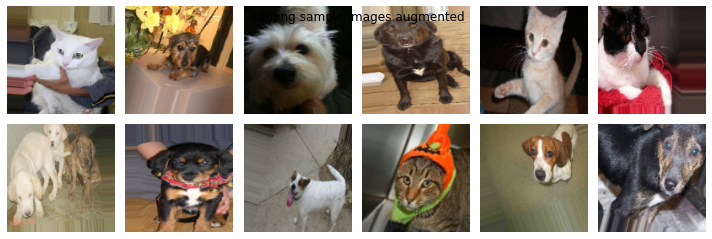

In [20]:
fig = plt.figure(1, figsize = (10, 10))
fig.suptitle("Training sample images augmented")

for i in range(12):

    plt.subplot(6, 6, i + 1)
    image, label = train_generator.next()
     # display the image from the iterator
    plt.imshow(image[0])
    plt.axis("off")
    
plt.tight_layout()
plt.savefig('./train_sample_images_augmented.png')

plt.show()

# Model

### Define  callbacks

In [21]:
early_stop = EarlyStopping(patience=10)

lr_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)
# mc = ModelCheckpoint(filepath = './best_model.h5',save_best_only=True,
                                                    #  verbose=0)
mc = ModelCheckpoint('./saved_models/save_at_{epoch}.h5')

callbacks = [
    early_stop,
    lr_reduction,
    mc
]

### Build a model

In [22]:
# model = tf.keras.models.Sequential([
#     # Note the input shape is the desired size of the image with 3 bytes color
#     # This is the first convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(128, 128, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     # The second convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # The third convolution
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # The fourth convolution
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # Flatten the results to feed into a DNN
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5),
#     # 512 neuron hidden layer
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])


# model.summary()

In [23]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [24]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

### Train the model

In [25]:
model_name = 'CNN'
print(model_name)
# training
print('training the model...')
start = time.time()
with tf.device("/GPU:0"): # use GPU-kernel 
  hist = model.fit(train_generator,
          validation_data = val_generator,
          epochs=50,
          batch_size=batch_size,
          verbose = 1,
          validation_steps=3,
          callbacks=callbacks)
print('It takes ',round((time.time()-start)/60), 'mins to train the model.')

model.save('./final_' + model_name +'.h5')

CNN
training the model...
Epoch 1/50
500/500 [==============================] - 129s 252ms/step - loss: 0.7625 - accuracy: 0.6006 - val_loss: 0.7104 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 2/50
500/500 [==============================] - 123s 246ms/step - loss: 0.6197 - accuracy: 0.6568 - val_loss: 0.7464 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 3/50
500/500 [==============================] - 120s 240ms/step - loss: 0.5720 - accuracy: 0.6987 - val_loss: 0.6097 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/50
500/500 [==============================] - 119s 238ms/step - loss: 0.5392 - accuracy: 0.7283 - val_loss: 2.1787 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/50
500/500 [==============================] - 130s 260ms/step - loss: 0.5081 - accuracy: 0.7489 - val_loss: 0.4904 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 6/50
500/500 [==============================] - 122s 243ms/step - loss: 0.4829 - accuracy: 0.7667 - val_loss: 0.4504 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 7/50
500/500 [

### Evaluate the model

       loss  accuracy  val_loss  val_accuracy     lr  epoch
0  0.762546  0.600625  0.710368      0.583333  0.001      1
1  0.619697  0.656750  0.746355      0.541667  0.001      2


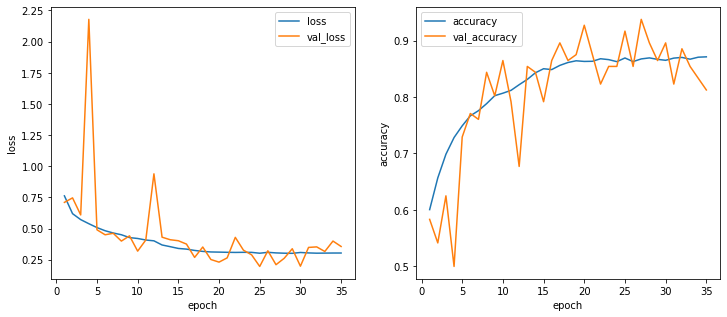

In [26]:
learning_curve(hist)

In [27]:
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print('Test acc:', test_acc)
test_data_pred = model.predict(test_generator)
test_data.loc[:, "test_data_pred"] = np.around(test_data_pred).astype(int)
test_data["test_data_pred"] = test_data["test_data_pred"].replace({1: 'dog', 0:'cat'})

Test acc: 0.9014000296592712


In [28]:
print(classification_report(test_data["label"], test_data["test_data_pred"]))

              precision    recall  f1-score   support

         cat       0.87      0.94      0.91      2500
         dog       0.94      0.86      0.90      2500

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



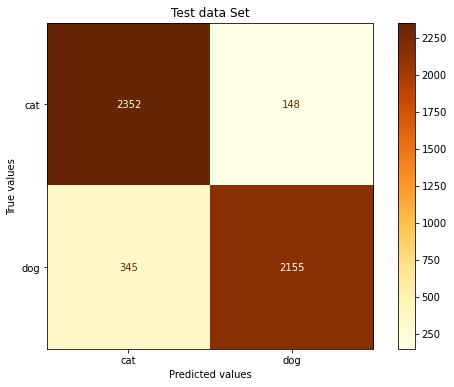

In [29]:
conf_matrix(test_data)

### Show some wrong predicted images

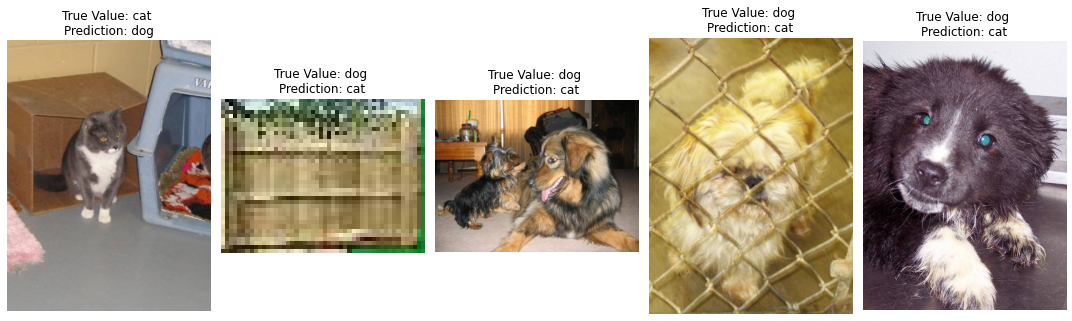

In [31]:
test_data_errors = test_data[(test_data.label) != (test_data.test_data_pred)].reset_index(drop = True)

fig = plt.figure(1, figsize = (15, 5))
for i in range(5):
    
    plt.subplot(1, 5, i + 1)
    image = load_img("/content/train/" + test_data_errors.image_name[i])
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"True Value: {test_data_errors['label'][i]} \nPrediction: {test_data_errors['test_data_pred'][i]}")    
    
plt.tight_layout()
plt.savefig('./wrong_pred.png')
plt.show()